## Setting up the model: OLG with PAYG

This project sets up the overlapping generations model, like the one originally proposed by Diamond (1965), which is a macroeconomic model whose aim is to analyze the macroeconomic dynamics and economic growth.

The key assumption made is the population turnover: people only live for 2 periods, they are young and they work at the first period of their lives, they are old and are considered 'retirees' in the second period of their lives and then they die. In that setting, the economy and growth have still infinite horizon but individuals do not. Each period a new generation is born and an old one dies. We assume that n is the growth of the population.


Moreover, we assume that the constant relative risk aversion (CRRA) coefficient is equal to 1, such that households have logarithmic utility which makes the calculations simpler without depriving the model of the completeness and the ability to draw more general conclusions. 

Furthermore, we assume that the young supply 1 unit of labor that is supplied inelastically, meaning that in that model there is no unemployment as well as no labor market. Factors are paid their marginal products.

We consider the **Overlapping generations model with a Pay-as-you-go system** where:

1. $c_{1t}$ is consumption for agents young in period ${t}$
2. $c_{2t+1}$ is consumption for agents old in period ${t+1}$
3. $\tau_{t}$ is the social security contribution when young
4. $K_t$ is aggregate capital
5. $L_t$ is aggregate labor (growing with a constant rate of $n$)
6. $A$ is technology
7. $Y_t = F(K_t,L_t)$ is output 
8. $w_{t}$ is marginal product of labor 
9. $R_{t+1}=1 + r_{t+1} - \delta $ is Gross interest rate
10. $r_{t}$ is marginal product of capital 

We assume housholds have **log preferences** and max lifetime **utility** according to 

$$\max_{\{c_{1t},c_{2t+1}\}}\log u(c_{1t})+ \beta \log u(c_{2t+1})$$

\begin{align*}
&s.t\\
&c_{1t}=w_{t}-{\tau_{t}}-s_{t}\\
&c_{2t+1}=R_{t+1}s_{t}+\tau_{t}(1+n)
\end{align*}

So individuals born at t are earning a wage from their work at period t which can be used to finance their consumption, their proportional to their wage taxes and their savings for the next period when they will be old. At period t+1 they consume everything they have: their savings plus their interest rate from the previous period as well as the benefits the government gives them via the social security system. 

From the maximization problem we optain the **Euler Equation** that characterizes **houshold saving behavior**

$$u'(c_{1t})+ \beta R_{t+1}u'(c_{2t+1})$$

The level of **capital per worker** in steady state is according to

$$ k_{t+1}=\frac{1}{[1+\frac{1}{1+\beta}\frac{1-\alpha}{\alpha}\tau]}\frac{\beta}{{(1+n)}{(1+\beta)}}w_t(1-\tau)$$

Such that the individual **savings** schedule is
$$ s_t = (1+n)k_{t+1}$$

We assume the **production function** is **Cobb-Douglas** and displays constant returns to scale

$$ F(K_{t},L_{t})=A(K_{t})^{\alpha}(L_{t})^{1-\alpha}$$

Note that capital letters (like $K_{t}$ ) are referring to the aggregate values while lowercase characters (like $k_{t}$) represent  per capita values. We focus our analysis on what happens in per capita terms.

$$ k_t = \frac{K_t}{L_t} $$

We assume competitive pricing of our factor prices, so the FOC give: 
$$ r = A\alpha{k_t}^{(\alpha-1)} $$
$$ w = (1-\alpha)k_t^\alpha $$


In [3]:
# Importing all necessary Packages
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import ipywidgets as widget

In [4]:
# Defining all variables 
alpha = 0.33 # Allocation
delta = 0.10 # Depreciation rate
A = 9.0 # Technology
beta = 0.8 # Patience paramater
tax = 0.3 # Social Security tax 
n = 0.10 # Population grwoth rate
k_min = 0.01 # Minimum capital level
k_max = 5.00 # Maximum capital level

## Solving the OLG model with PAYG System


In [5]:
# a. Create function that caluclates competitive factor prices and output
def factor_prices(k, delta, A, alpha):
    '''
    Function to aggregate factor prices 
    
    Arguments:
    k(float): Capital per person
    delta(float): Depreciation rate
    A(int): Technology
    alpha(float): Capital Allocation

    Returns:
    R(float): Gross interest rate
    w(float): Wage rate
    '''
    # Note that labor is not present within the model because we assume that there is 1 unit of labor in the model. 
    
    output = A*k**alpha # Total output subject to capital per person
    r = A*alpha*k**(alpha-1) # Calculating capital rental rate, FOC of Cobb Douglas with respect to k 
    R = 1 + r - delta # Calculating Gross interest rate
    
    w = output - r*k # Calculating wage rate because 0 = output - r*k - w*l, due to competitive markets
    
    return R, w

In [6]:
# b. Create Utility function that will be used in optimization problem  

def utility(s, w, tax, R_update, beta, n):
    '''
    Used to calculate aggregate utility across both cohorts
    
    Arguments:
    s(float): Savings 
    w(float): Wage rate
    tax(float): PAYG tax rate
    R_update(float): Gross interest rate at t+1
    beta(float): Patience paramater
    n(float): Population Growth Rate
    
    
    Returns:
    Total utility between the young and old cohorts
    '''
    
    T = w*tax # Portion of wage that is transferred to the old cohort
    
    # Sum of utility across cohorts
    
    U = np.log(w - T - s) + beta*np.log(R_update * s + T*(1+n))
    
    return U

In [7]:
# c. Create maximization problem using the utility function in order to find optimal levels of savings 

def optimize_savings(w, R_update, tax):
    '''
    Find optimal savings
    
    Arguments:
    w(float): Wage rate
    R_update(float): Gross interest rate at t+1
    tax(float): PAYG tax rate

    Returns:
    yields optimal level of savings given wage and future gross interest rate
    '''
    
    # Create negative util function for minimization
    s = optimize.fminbound(lambda s: -utility(s, w, tax, R_update, beta, n), 0, w)
    
    return s

In [8]:
# d. Create function that minimizes the deviation between our capital at t+1 and optimal savings 

def min_dev(k_update, k_min, k_max, tax):
        '''
        Function that calculates the value of k that achieves the steady state
        
        Arguments:
        k_update(float): Capital per person at t+1
        k_min(float): Minimum capital per person in model
        k_max(float): Maximum capital per person in model
        tax(float): PAYG tax rate
        
        returns:
        Value of k that achieves the level of savings to make savings equivalent to capital per person at t+1
        '''

        # i. Generate Factor prices at t+1
        R_update, w_update = factor_prices(k_update, delta, A, alpha)

        # ii. Create Sub-function to be used for optimization problem
        def min_function(k):

            R, w = factor_prices(k, delta, A, alpha)
            s = optimize_savings(w, R_update, tax)

            return (k_update - s/(1 + n)) ** 2 # Must be squared in order to prevent negative values 

        # iii. Find optimal level of capital per person at t
        k = optimize.fminbound(min_function, k_min, k_max)

        return k
    

In [16]:
# d. Solve the model
def find_values(k_min, k_max, tax, n):
    '''
    Output lists of all of our key outputs
    
    Arguments:
    k_min(float): Minimum capital per person in model
    k_max(float): Maximum capital per person in model
    tax(float): Redistributive tax
    n(float): Number of seperations between min and max capital in the model
    
    Returns:
    key outputs of the model
    '''
    # i. Generate empty lists for all of our key variables
    num = 100
    k_update_vector = np.linspace(k_min, k_max, num) # numpy array of cap per per. at t+1
    k_vec = [] # Capital per person at t
    s_vec = [] # List of savings
    R_vec = [] # List of gross interest rate at t+1
    w_fut_vec = [] # List of wage rate at t+1
    w_vec = [] # List of wage rate at t
    c_young_vec = [] # List of consumption when young
    c_old_vec = [] # List of Consumption when old
    
    # ii. Solve for our key variables 
    for k_update in k_update_vector:
        k = min_dev(k_update, k_min, k_max, tax)
        k_vec.append(k)
        R_fut, w_fut = factor_prices(k_update, delta, A, alpha)
        R, w = factor_prices(k, delta, A, alpha)
        R_vec.append(R_fut)
        w_fut_vec.append(w_fut)
        w_vec.append(w)
        s = optimize_savings(w, R_fut, tax)
        s_vec.append(s)
        c_young = w - s - w*tax
        c_old = R_fut*s + w*tax*(1+n)
        c_young_vec.append(c_young)
        c_old_vec.append(c_old)
        
    
    return k_vec, s_vec, R_vec, w_vec, c_young_vec, c_old_vec

In [36]:
k_update_vector = np.linspace(k_min, k_max, 100)
taxes=[0.0, 0.1, 0.2, 0.3]

def ss(k_update_vector, k_vec):
    
    diff = []
    for i in range(100): 
        x = abs(k_update_vector[i]-k_vec[i])
        if k_vec[i]> 0.1 and k_vec[i]< 4.9 and x<0.06:
            print(k_vec[i])
        else:
            continue 
        
for tax in taxes:
    k_vec, s_vec, R_vec, w_vec, c_young_vec, c_old_vec = find_values(k_min, k_max, tax, n)
    print('The Steady state with ' +str(tax)+ ' tax')
    steady = ss(k_update_vector, k_vec)


The Steady state with 0.0 tax
3.816028447177855
The Steady state with 0.1 tax
2.96278597136893
The Steady state with 0.2 tax
2.126297377726059
The Steady state with 0.3 tax
1.6503081914344424


We have now solved the model and created lists of all of the key variables in the model. We have found level of capital at t, optimal savings, gross interest rate at t+1, wage rate at t, consumption when young and consumption when old. The next step is to plot our model observing some of these key variables in order to determine how dynamics change when introducing a PAYG system. 

## Plotting: OLG Dynamics Under a PAYG System

Text(0, 0.5, '$k_{t+1}$')

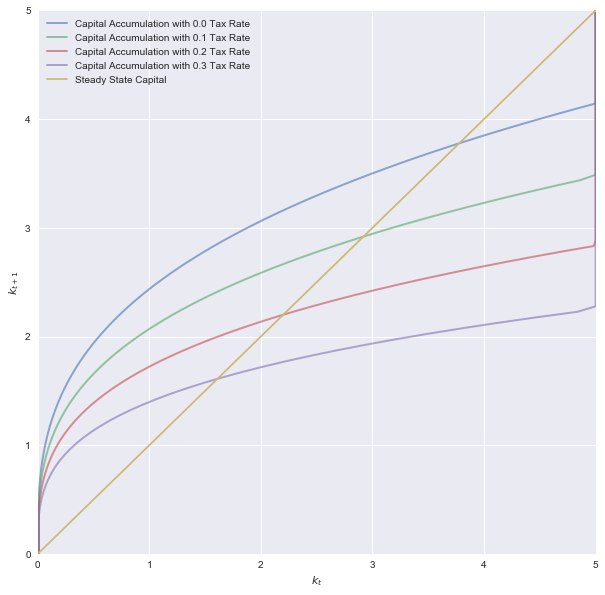

In [18]:
# a. output the capital accumulation curve when tax rate adjusts
k_update_vector = np.linspace(k_min, k_max, 100)
fig, ax = plt.subplots(figsize=(10,10))

# i. loop through all levels of tax and plot
taxes=[0.0, 0.1, 0.2, 0.3]
for tax in taxes:
    k_vec, s_vec, R_vec, w_vec, c_young_vec, c_old_vec = find_values(k_min, k_max, tax, n)
    ax.plot(k_vec, k_update_vector, linewidth=2, alpha=0.6, label='Capital Accumulation with '+str(tax)+' Tax Rate')

# ii. Set plot labels, limits, and constant plots
ax.plot(k_vec, k_vec, label='Steady State Capital')
ax.legend()
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_xlabel("$k_t$")
ax.set_ylabel("$k_{t+1}$")

Given that capital accumulation function is concave in k_t and decreasing in tax rates, we see that **the higher tax rate would depress capital accumulation** in the economy and therefore would lead to a lower steady state level of capital.

This is happening via two chanels: 
first, because the **tax rates decrease the available income of the young** people so they have less to invest to capital with, and 
second, because **the expected income when old is increased**, since then they will get the 'benefit' from the social security system, therefore the incentives of saving/investing when young are lower.
These effects are also apparent in the last plot where we show the relation between wage rate and savings.

We also notice from the diagram that the **effect of an increase in the tax rate has decreasing marginal effect on capital accumulation**, meaning that we see that going from 0 tax rate to 0.1 leads to a larger decrease of capital in comparison with the size of the same effect when going from 0.2 tax rate to 0.3.

In case the economy is at a dynamically inefficient point the **taxes of the pay as you go system could in fact be used to restore the dynamic efficiency** and prevent the economy from overaccumulating capital.


Text(0, 0.5, '$R_{t+1}$')

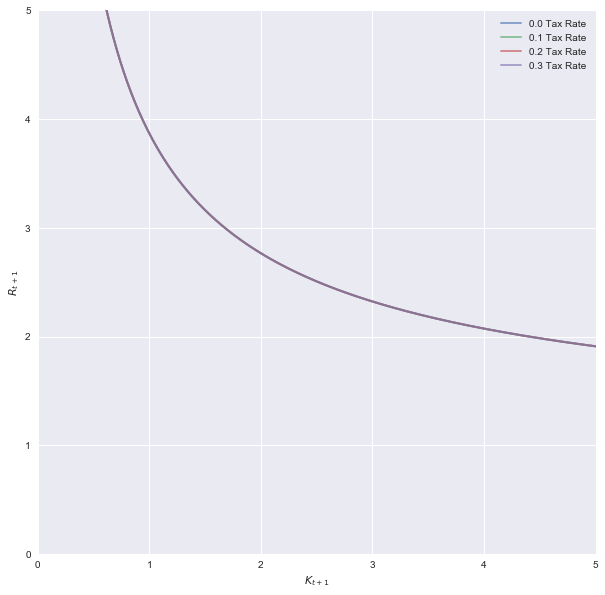

In [9]:
# b. Output the relationship between capital and interest rate when tax rate adjusts
fig, ax = plt.subplots(figsize=(10,10))

# i. loop through all levels of tax and plot
taxes=[0.0, 0.1, 0.2, 0.3]
for tax in taxes:
    k_vec, s_vec, R_vec, w_vec, c_young_vec, c_old_vec = find_values(k_min, k_max, tax, n)
    ax.plot(k_update_vector, R_vec, linewidth=2, alpha=0.6, label=str(tax)+' Tax Rate')


# ii. Set plot labels and limits
ax.legend()
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_xlabel("$K_{t+1}$")
ax.set_ylabel("$R_{t+1}$")

Plotting the relationship between interest rate and the capital level of the next period in our economy we see, as we would expect, that **higher capital leads to lower interest rate**. 

As interest rate is defined by the sum of the rental rate of capital, which is directly affected by how much capital the economy has, plus the non depreciated rate of it, which isn't affected by the size of the capital in the economy. Therefore it makes sense that **the more capital we have, for the same amount of workers, the less productive each capital unit is**. Since the rental rate reflects just the marginal product of the capital it is reasonable this negative relation to exist.

Adjusting for different possible rates of taxes we see that nothing changes - functions just overlap each other, meaning that **different tax rates do not affect the relation between interest rate and the level of capital**. 
The intuition behind that result is that taxes do affect the level of capital in the economy and therefore the level of interest rate but not the relation between them. That means that taxes only enter in the function of interest rate via the level of capital, therefore they do not have any direct effect on the rental rate itself. This is a reasonable result since in our current setting factors are just rewarded by their marginal products and there's no way that taxes affects their productivity.


Text(0, 0.5, 'Savings')

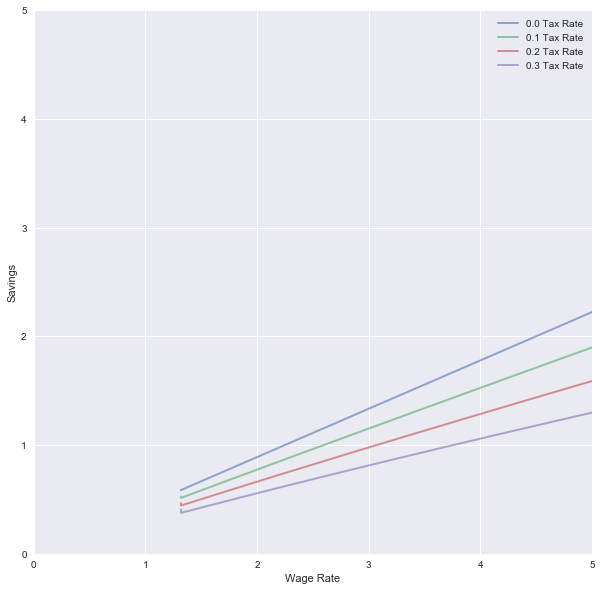

In [36]:
# c. Output the relationship between wage rate and savings when tax rate adjusts
fig, ax = plt.subplots(figsize=(10,10))

# i. loop through all levels of tax and plot
taxes=[0.0, 0.1, 0.2, 0.3]
for tax in taxes:
    k_vec, s_vec, R_vec, w_vec, c_young_vec, c_old_vec = find_values(k_min, k_max, tax, n)
    ax.plot(w_vec, s_vec, linewidth=2, alpha=0.6, label=str(tax)+' Tax Rate')

# ii. Set plot labels and limits
ax.legend()
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_xlabel("Wage Rate")
ax.set_ylabel("Savings")

As mentioned earlier, that plot shows the relation between savings and wage income. **The higher the wage income, the more people tend to save** since they want want to smooth their consumption profile across their lifetime, as shown but the Euler Equation. 

When adjusting for different tax rates we see that **savings are indeed affected by how large the social security is**, meaning that for the same, before taxes, wage income **a higher tax rate would decrease more the individuals' tendency towards saving**.

## Conclusion

This project's aim was to present and analyze the basic characteristics of the OLG - or Diamond's - macroeconomic model. 

OLG model is based on some usual economic concepts as that **people act atomistically trying to maximize their own utility** which is always positively, but with decreasing marginal rate, affected by their consumption of each period. In the presented framework people only live for two periods and each generation overlaps another in a way such that economy as a total has an infinite horizon but individuals only live for 2 periods. These assumptions are not depriving the model of the completeness and the ability to draw more general conclusions, **people living for 2 periods is not qualitively different than people who live more as long as the population does the turnover**.

Assuming that they work only while young and that there is a pay-as-you-go social security system which uses young people's taxes to finance old people's benefits on a period by period basis, we found that, as expected, **the larger that social security is the less incentive people have to save** for their own consumption when old. Since in our framework savings are used to finance capital the less people tend to save the less capital per worker we tend to have in equilibrium. That means that **the larger the social security the more it decreases steady state level of capital**. This could then be used by the government in order to restore dynamic efficiency in periods when the economy is dynamically inefficient and therefore tends to overaccumulate capital. 

We also saw that **taxes do not affect the way interest rate reacts to a certain level of capital**, meaning that the size of social security does not move that function at all, it only affects the point where the economy will be on it. 

